In [168]:
# Import Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist

%matplotlib inline

In [169]:
# Read in the data
df = pd.read_csv('https://github.com/doski-codes/bpnn-ngsim-congestion/blob/master/NGSIM_US101.csv?raw=true')

In [170]:
df.head()

,Unnamed: 0,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Congestion
0,0,515,2330.0,1123.0,1.118848e+12,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0
1,1,515,2330.0,1123.0,1.118848e+12,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0
2,3,2127,6459.0,567.0,1.118848e+12,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0
3,4,1033,4827.0,592.0,1.118848e+12,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0
4,5,1033,4827.0,592.0,1.118848e+12,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0


In [171]:
df.drop(columns=['Unnamed: 0', 'Congestion'], inplace=True)

In [172]:
df.drop_duplicates(inplace=True)

In [173]:
df.dropna(inplace=True)

In [174]:
df.describe()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway
count,455846.000000,455846.000000,455846.000000,4.558460e+05,455846.000000,455846.000000,4.558460e+05,4.558460e+05,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,1335.086031,5296.503345,739.689195,1.118848e+12,29.741326,1043.131800,6.451849e+06,1.872668e+06,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,1272.369618,1276.829528,67.275576,191.713501
std,788.495635,2664.308538,204.465991,7.693255e+05,16.588804,603.410021,4.511053e+02,4.008011e+02,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,815.509491,817.265165,41.049844,1360.754989
min,1.000000,10.000000,160.000000,1.118847e+12,0.369000,3.051000,6.451067e+06,1.871889e+06,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,668.000000,2981.000000,568.000000,1.118848e+12,17.607000,521.866000,6.451455e+06,1.872329e+06,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,571.000000,574.000000,43.430000,1.670000
50%,1321.000000,5535.000000,738.000000,1.118849e+12,29.780000,1003.489500,6.451817e+06,1.872690e+06,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,1259.000000,1262.000000,59.660000,2.280000
75%,1901.000000,7645.000000,904.000000,1.118849e+12,41.767750,1553.459000,6.452230e+06,1.873010e+06,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,1868.000000,1873.000000,82.580000,3.190000
max,3109.000000,10000.000000,1328.000000,1.118850e+12,75.682000,2217.411000,6.452733e+06,1.873401e+06,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,3109.000000,3109.000000,771.160000,9999.990000


In [175]:
df['Global_Time'] = pd.to_datetime(df['Global_Time'], unit='ms').dt.tz_localize('GMT').dt.tz_convert('US/Pacific')

In [176]:
df['Hours'] = df.Global_Time.dt.hour / 24
df['Minutes'] = df.Global_Time.dt.minute / 60

In [177]:
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes
0,515,2330.0,1123.0,2005-06-15 08:07:55-07:00,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0.333333,0.116667
2,2127,6459.0,567.0,2005-06-15 08:00:24.800000-07:00,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0.333333,0.000000
3,1033,4827.0,592.0,2005-06-15 08:12:04.700000-07:00,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0.333333,0.200000
5,1890,9157.0,628.0,2005-06-15 08:34:32.700000-07:00,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,0.333333,0.566667
6,744,3392.0,996.0,2005-06-15 08:09:41.200000-07:00,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,0.333333,0.150000


In [178]:
global_time = df.Global_Time

In [179]:
df.drop(columns='Global_Time', inplace=True)

In [180]:
data_ = df.iloc[:, 2:]

In [181]:
data = data_.drop(columns=['Preceding', 'Following', 'Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width'])

In [182]:
data.reset_index(inplace=True, drop=True)

In [183]:
data.head()

,Total_Frames,v_Class,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,Hours,Minutes
0,1123.0,2.0,23.31,2.05,3.0,119.10,5.11,0.333333,0.116667
1,567.0,2.0,37.52,11.20,2.0,48.92,1.30,0.333333,0.000000
2,592.0,2.0,41.99,0.10,1.0,38.81,0.92,0.333333,0.200000
3,628.0,3.0,45.12,-0.55,5.0,102.65,2.27,0.333333,0.566667
4,996.0,2.0,24.54,-0.04,3.0,37.80,1.54,0.333333,0.150000


# Clustering

In [184]:
data.columns

Index(['Total_Frames', 'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID', 'Space_Headway',
       'Time_Headway', 'Hours', 'Minutes'],
      dtype='object')

In [185]:
num_cols = ['Total_Frames', 'v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway']

In [186]:
cat_cols = ['v_Class', 'Lane_ID']

In [187]:
for col in cat_cols:
  data[col] = LabelEncoder().fit_transform(data[col])

In [188]:
clus_df = normalize(data)

In [189]:
clustering_df = pd.DataFrame(clus_df, columns=data.columns)

In [190]:
clustering_df.head()

,Total_Frames,v_Class,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,Hours,Minutes
0,0.994198,0.000885,0.020636,0.001815,0.001771,0.105440,0.004524,0.000295,0.000103
1,0.993943,0.001753,0.065772,0.019633,0.001753,0.085756,0.002279,0.000584,0.000000
2,0.995365,0.001681,0.070600,0.000168,0.000000,0.065254,0.001547,0.000560,0.000336
3,0.984400,0.003135,0.070726,-0.000862,0.006270,0.160906,0.003558,0.000523,0.000888
4,0.998974,0.001003,0.024613,-0.000040,0.002006,0.037913,0.001545,0.000334,0.000150


In [191]:
pca_cluster = PCA(n_components = 6, random_state=135).fit_transform(clustering_df)

In [192]:
pca_cluster = pd.DataFrame(pca_cluster)

### Picking number of clusters

In [193]:
pca_cluster_ = PCA(n_components = 2, random_state=135).fit_transform(clustering_df)

In [194]:
pca_cluster_ = pd.DataFrame(pca_cluster_)

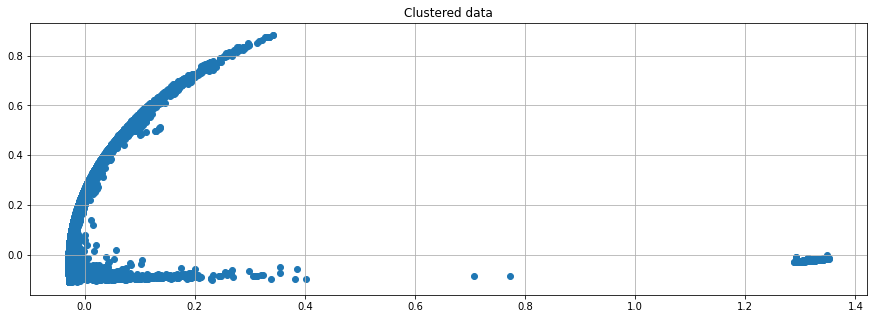

In [195]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(pca_cluster_.iloc[:, 0], pca_cluster_.iloc[:, 1])
plt.grid(True)
plt.title('Clustered data')
plt.show()

In [196]:
kmeans3 = KMeans(n_clusters=2).fit(pca_cluster_)

In [197]:
colours = {0:'red', 1:'yellow', 2:'green'}

In [198]:
kmeans3 = pd.Series(kmeans3.labels_).replace(colours)

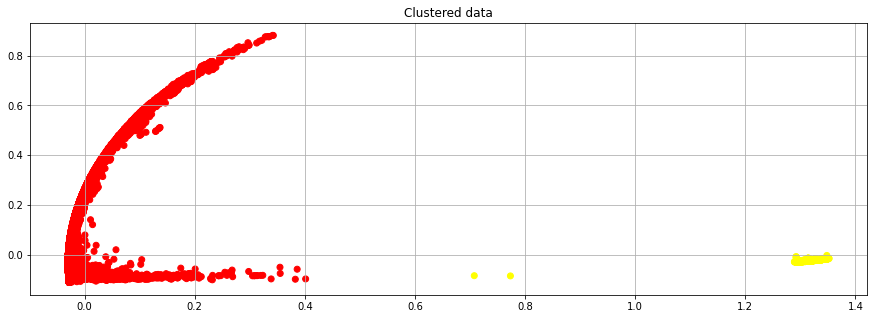

In [199]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(pca_cluster_.iloc[:, 0], pca_cluster_.iloc[:, 1], c=kmeans3)
plt.grid(True)
plt.title('Clustered data')
plt.show()

#### Non PCA cluster check

In [200]:
wss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(clustering_df)
    wss.append(kmeans.inertia_)

In [201]:
wss

[18603.978017214264,
 3367.8850942368053,
 1622.294331209291,
 1047.6653489428438,
 796.9293292688013,
 652.1985578326806,
 533.96218933209,
 449.3345587072976,
 397.0409384916172,
 360.64263374190307]

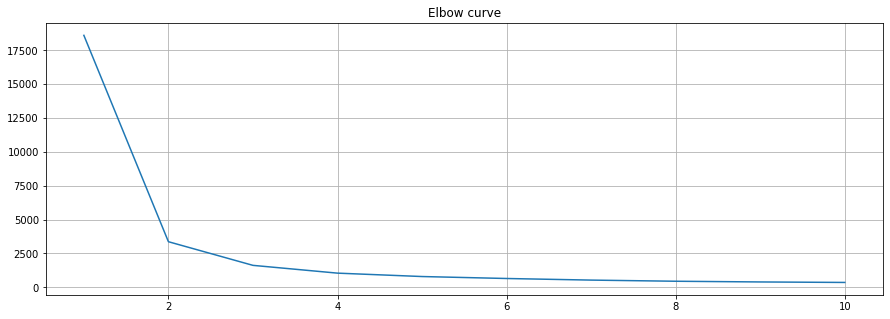

In [202]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), wss)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [203]:
elbows = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(clustering_df)
    elbows.append(sum(np.min(cdist(clustering_df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / clustering_df.shape[0])

In [204]:
elbows

[0.09511994976582376,
 0.06277143102660793,
 0.044579843961205935,
 0.03658029950711644,
 0.03211694341718182,
 0.029404280675359443,
 0.027392025157826284,
 0.025270813141978266,
 0.023771724101928557,
 0.022571857059675286]

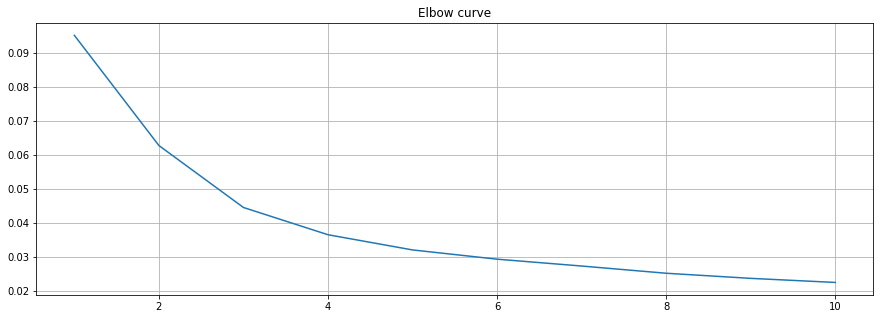

In [205]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), elbows)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [206]:
db_index = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(clustering_df)
    db_index.append(metrics.davies_bouldin_score(clustering_df, kmeans.labels_))

In [207]:
db_index

[0.05525922699731241,
 0.48562323342607705,
 0.5519107745932945,
 0.6185846774716334,
 0.6697152636102178,
 0.6392079114229807,
 0.6718940713151125,
 0.7153444687658577,
 0.7772982500163825]

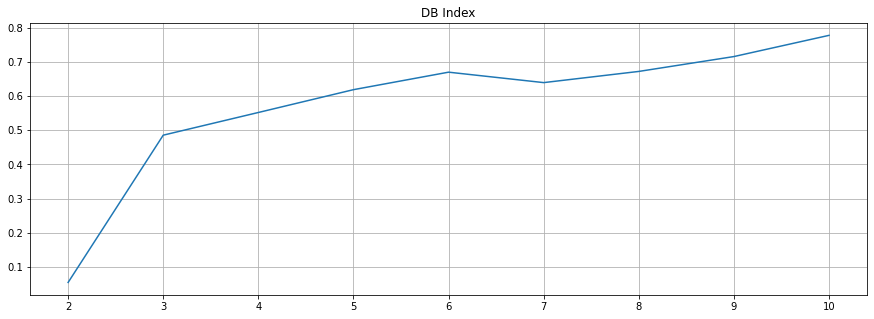

In [208]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), db_index)
plt.grid(True)
plt.title('DB Index')
plt.show()

#### PCA cluster check

In [209]:
wss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(pca_cluster)
    wss.append(kmeans.inertia_)

In [210]:
wss

[18603.81705469913,
 3367.7241323332723,
 1622.1492106179307,
 1047.524544341286,
 796.8600640182008,
 651.9354635443434,
 533.8520065621609,
 449.2604246530181,
 396.7071581331578,
 360.48778099284317]

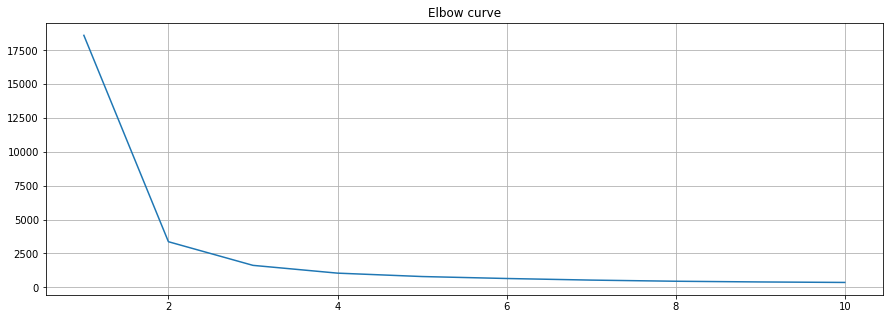

In [211]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), wss)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [212]:
elbows = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(pca_cluster)
    elbows.append(sum(np.min(cdist(pca_cluster, kmeans.cluster_centers_, 'euclidean'), axis=1)) / pca_cluster.shape[0])

In [213]:
elbows

[0.09511720421879909,
 0.06276753690289993,
 0.044590779369521154,
 0.03657988739628584,
 0.03205844328352688,
 0.029384660779586562,
 0.027442511364085386,
 0.025402440088846755,
 0.023741097018179818,
 0.02258128538842261]

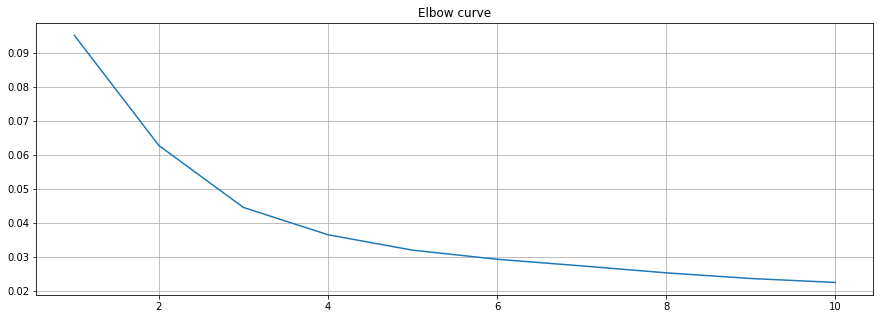

In [214]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), elbows)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [215]:
db_index = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(pca_cluster)
    db_index.append(metrics.davies_bouldin_score(pca_cluster, kmeans.labels_))

In [216]:
db_index

[0.05525615815997244,
 0.48544833529700265,
 0.5516171944635437,
 0.6177700117663448,
 0.676556944749826,
 0.6394786104975978,
 0.6732055944424464,
 0.7202814771275761,
 0.7732964201512946]

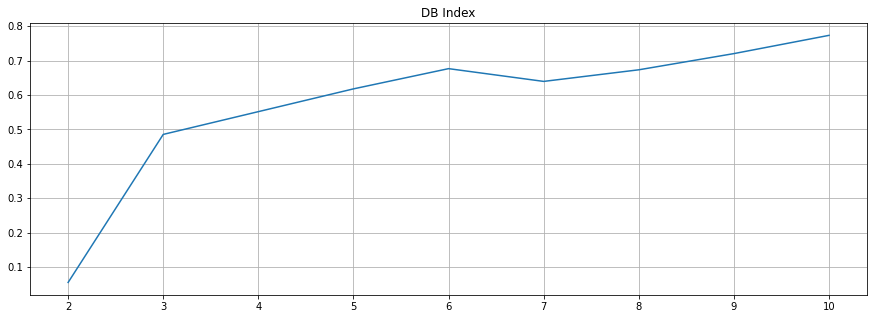

In [217]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), db_index)
plt.grid(True)
plt.title('DB Index')
plt.show()

Lowest DB Index values for different PCA components

* PCA = 2, DBI = 0.048504353792782666 for k = 2
* PCA = 3, DBI = 0.05272366033571618 for k = 2
* PCA = 4, DBI = 0.05476090858087586 for k = 2
* PCA = 5, DBI = 0.055203878942769236 for k = 2
* PCA = 6, DBI = 0.05525615815997244 for k = 2
* No PCA, DBI = 0.05525922699731241 for k = 2


### K Means Clustering

In [218]:
kmeans_cluster = KMeans(n_clusters=2, random_state=123).fit(clustering_df)

In [219]:
# Silhouette Score
# silhouette_score = metrics.silhouette_score(clustering_df, kmeans_cluster.labels_)
# print(silhouette_score)
#0.9338283030028897

In [220]:
kmeans_cluster.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [221]:
kmeans_df = data.copy()

In [222]:
kmeans_df['Hours'] = kmeans_df['Hours'] * 24
kmeans_df['Minutes'] = kmeans_df['Minutes'] * 60

In [223]:
kmeans_df['Congestion'] = kmeans_cluster.labels_

In [224]:
kmeans_df['Congestion'].value_counts()

0    447236
1      8610
Name: Congestion, dtype: int64

In [225]:
kmeans_df.head()

,Total_Frames,v_Class,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,Hours,Minutes,Congestion
0,1123.0,1,23.31,2.05,2,119.10,5.11,8.0,7.0,0
1,567.0,1,37.52,11.20,1,48.92,1.30,8.0,0.0,0
2,592.0,1,41.99,0.10,0,38.81,0.92,8.0,12.0,0
3,628.0,2,45.12,-0.55,4,102.65,2.27,8.0,34.0,0
4,996.0,1,24.54,-0.04,2,37.80,1.54,8.0,9.0,0


In [226]:
kmeans_df.describe()

,Total_Frames,v_Class,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,Hours,Minutes,Congestion
count,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,739.689195,1.016080,30.119328,0.159670,1.991453,67.275576,191.713501,7.833319,24.158093,0.018888
std,204.465991,0.162736,14.070791,4.550935,1.459117,41.049844,1360.754989,0.372691,16.528372,0.136130
min,160.000000,0.000000,0.000000,-11.200000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000
25%,568.000000,1.000000,20.000000,-0.770000,1.000000,43.430000,1.670000,8.000000,11.000000,0.000000
50%,738.000000,1.000000,30.240000,0.000000,2.000000,59.660000,2.280000,8.000000,22.000000,0.000000
75%,904.000000,1.000000,39.990000,1.380000,3.000000,82.580000,3.190000,8.000000,32.000000,0.000000
max,1328.000000,2.000000,95.300000,11.200000,7.000000,771.160000,9999.990000,8.000000,59.000000,1.000000


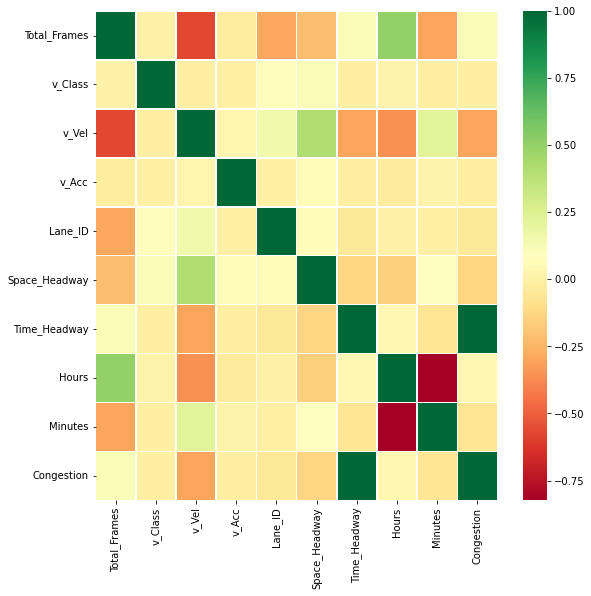

In [227]:
# Heatmap to show the correlation (Pearson's correlation) between the variables
corr = kmeans_df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corr, linewidth=0.5, cmap='RdYlGn')

In [228]:
kmeans_df['Global_Time'] = global_time

In [229]:
kmeans_df['Time'] = kmeans_df.Global_Time.dt.strftime('%H:%M:%S')

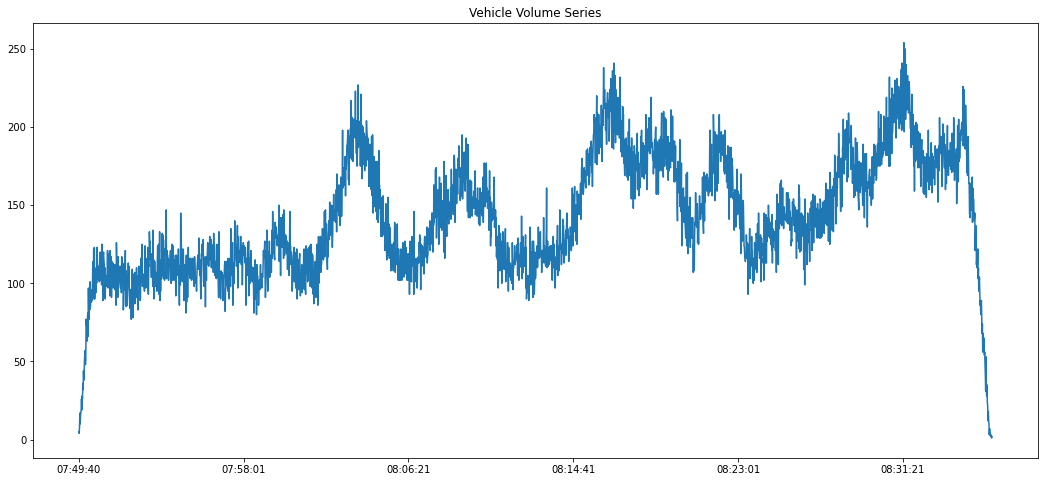

In [230]:
ax = kmeans_df.Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

In [231]:
plot_df = pd.DataFrame(kmeans_df.groupby('Congestion').Time.value_counts())
plot_df.columns = ['Count']
plot_df.reset_index(inplace=True)

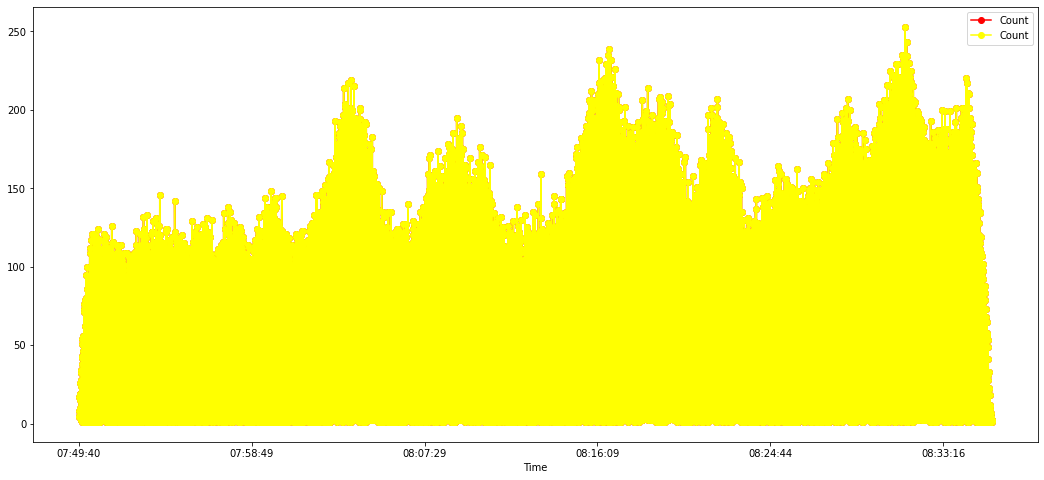

In [232]:
_, ax = plt.subplots(figsize=(18,8))

for congestion, time in plot_df.groupby('Congestion'):
     plot_df.sort_values('Time').plot('Time','Count', marker='o', ax=ax, color=colours[congestion])

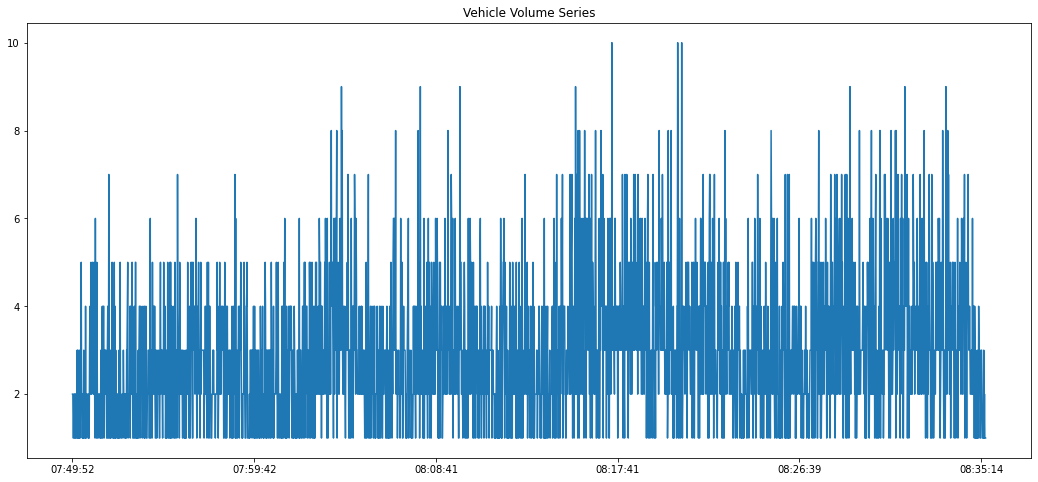

In [233]:
ax = kmeans_df[kmeans_df['Congestion'] == 1].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

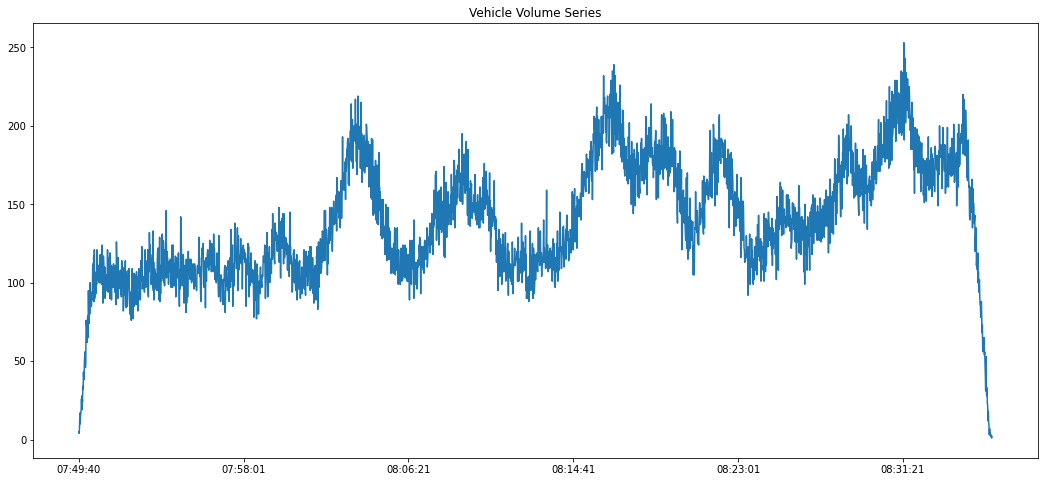

In [234]:
ax = kmeans_df[kmeans_df['Congestion'] == 0].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

In [235]:
pd.DataFrame(kmeans_df[kmeans_df.Congestion == 1].Time.value_counts()).reset_index().sort_values('index')

,index,Time
1785,07:49:52,2
2001,07:49:53,2
2388,07:49:55,1
2021,07:50:00,1
1579,07:50:01,2
...,...,...
2205,08:35:25,1
1874,08:35:36,2
2435,08:35:37,1
2405,08:35:41,1


In [236]:
kmeans_df['v_Class'].value_counts()

1    443656
2      9760
0      2430
Name: v_Class, dtype: int64

Vehicle volume time series for the various classes of vehicles

In [237]:
for cls in kmeans_df['v_Class'].unique():
  print(f'Vehicle Class: {cls} \n{kmeans_df[kmeans_df["v_Class"] == cls].Congestion.value_counts()} \n')

Vehicle Class: 1 
0    435114
1      8542
Name: Congestion, dtype: int64 

Vehicle Class: 2 
0    9707
1      53
Name: Congestion, dtype: int64 

Vehicle Class: 0 
0    2415
1      15
Name: Congestion, dtype: int64 



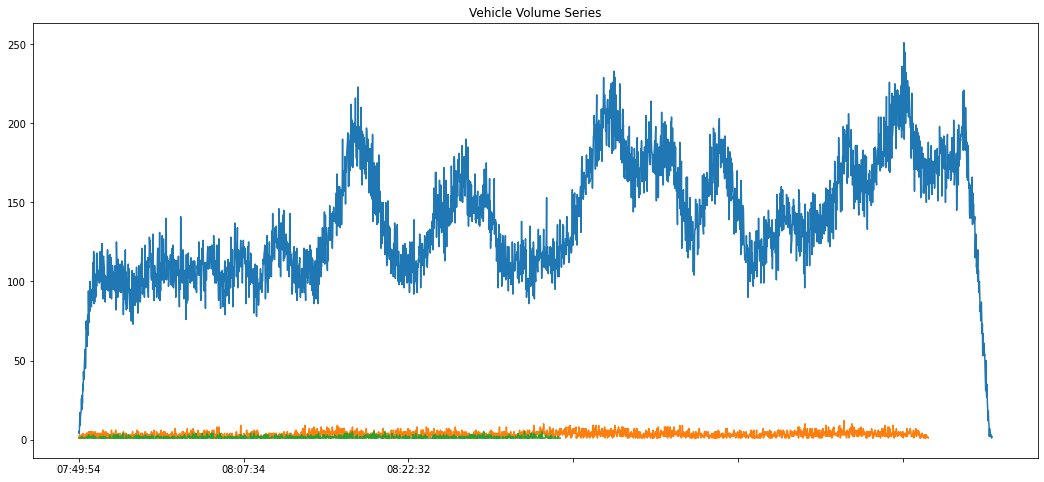

In [238]:
_, ax = plt.subplots(figsize=(18,8))

for cls in kmeans_df['v_Class'].unique(): 
  kmeans_df[kmeans_df['v_Class'] == cls].Time.value_counts().sort_index().plot(kind='line', ax=ax, 
                                              title='Vehicle Volume Series')

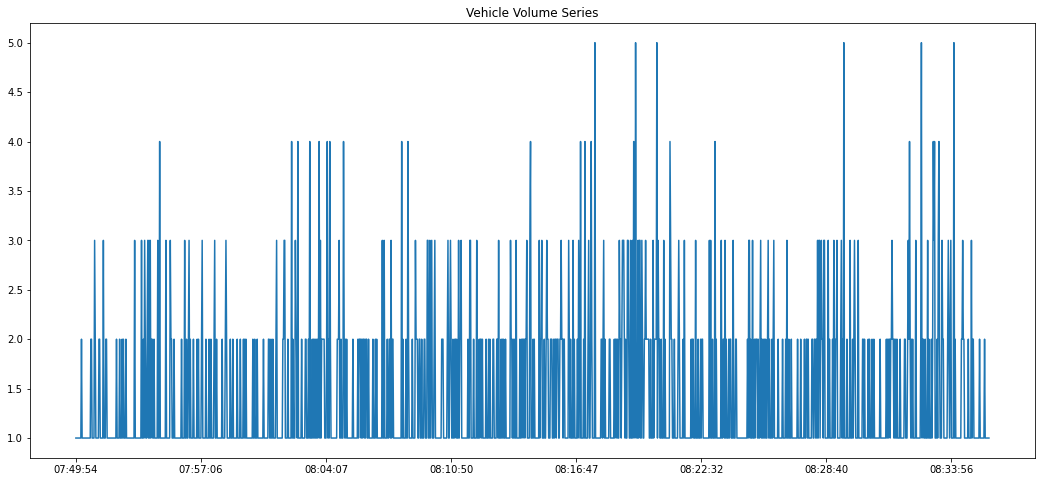

In [239]:
ax = kmeans_df[kmeans_df['v_Class'] == 0].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

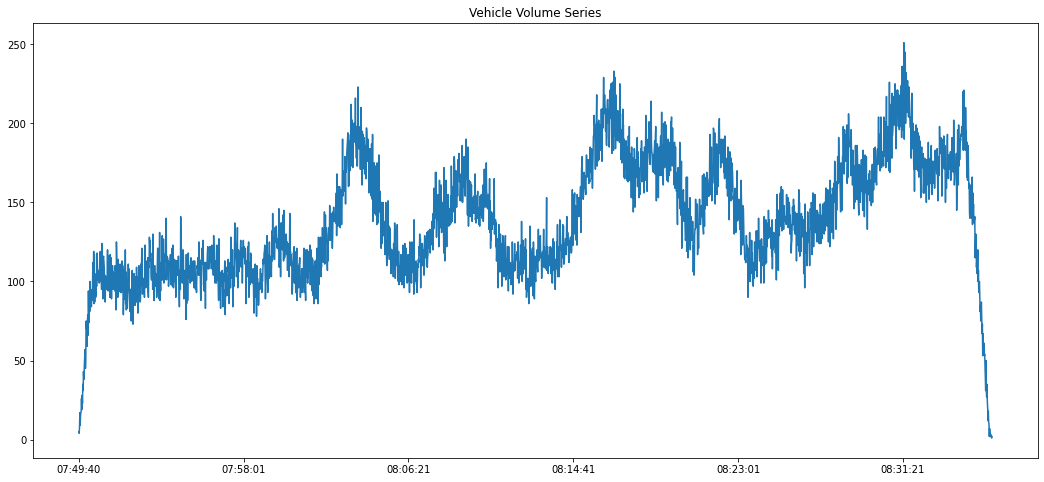

In [240]:
ax = kmeans_df[kmeans_df['v_Class'] == 1].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

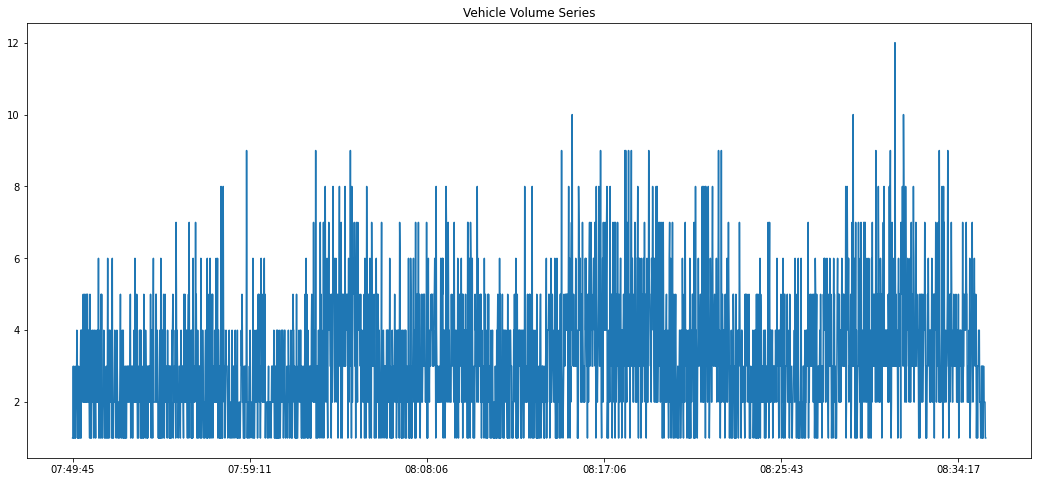

In [241]:
ax = kmeans_df[kmeans_df['v_Class'] == 2].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

##### KMeans on PCA data

In [242]:
kmeans_pca_cluster = KMeans(n_clusters=2, random_state=123).fit(pca_cluster)

In [243]:
# Silhouette Score
# silhouette_score = metrics.silhouette_score(pca_cluster, kmeans_pca_cluster.labels_)
# print(silhouette_score)

In [244]:
kmeans_pca_cluster.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [245]:
kmeans_pca_df = data.copy()

In [246]:
kmeans_pca_df['Hours'] = kmeans_pca_df['Hours'] * 24
kmeans_pca_df['Minutes'] = kmeans_pca_df['Minutes'] * 60

In [247]:
kmeans_pca_df['Congestion'] = kmeans_pca_cluster.labels_

In [248]:
kmeans_pca_df['Congestion'].value_counts()

0    447236
1      8610
Name: Congestion, dtype: int64

In [249]:
kmeans_pca_df.head()

,Total_Frames,v_Class,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,Hours,Minutes,Congestion
0,1123.0,1,23.31,2.05,2,119.10,5.11,8.0,7.0,0
1,567.0,1,37.52,11.20,1,48.92,1.30,8.0,0.0,0
2,592.0,1,41.99,0.10,0,38.81,0.92,8.0,12.0,0
3,628.0,2,45.12,-0.55,4,102.65,2.27,8.0,34.0,0
4,996.0,1,24.54,-0.04,2,37.80,1.54,8.0,9.0,0


In [250]:
kmeans_pca_df.describe()

,Total_Frames,v_Class,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,Hours,Minutes,Congestion
count,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,739.689195,1.016080,30.119328,0.159670,1.991453,67.275576,191.713501,7.833319,24.158093,0.018888
std,204.465991,0.162736,14.070791,4.550935,1.459117,41.049844,1360.754989,0.372691,16.528372,0.136130
min,160.000000,0.000000,0.000000,-11.200000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000
25%,568.000000,1.000000,20.000000,-0.770000,1.000000,43.430000,1.670000,8.000000,11.000000,0.000000
50%,738.000000,1.000000,30.240000,0.000000,2.000000,59.660000,2.280000,8.000000,22.000000,0.000000
75%,904.000000,1.000000,39.990000,1.380000,3.000000,82.580000,3.190000,8.000000,32.000000,0.000000
max,1328.000000,2.000000,95.300000,11.200000,7.000000,771.160000,9999.990000,8.000000,59.000000,1.000000


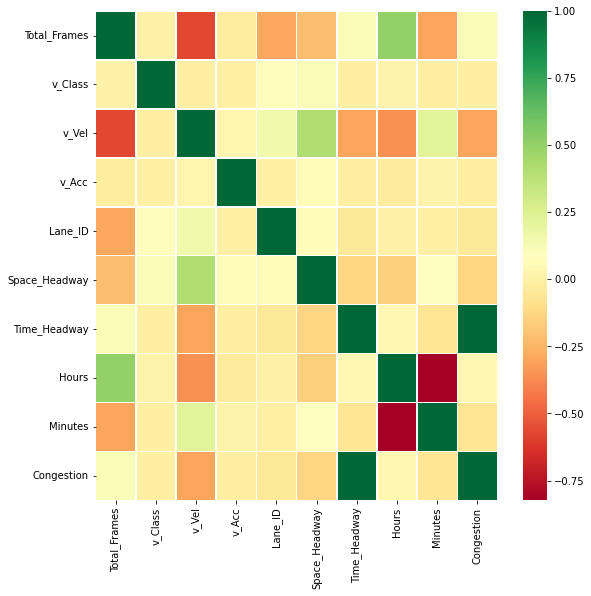

In [251]:
# Heatmap to show the correlation (Pearson's correlation) between the variables
corr = kmeans_pca_df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corr, linewidth=0.5, cmap='RdYlGn')

In [252]:
kmeans_pca_df['Global_Time'] = global_time

In [253]:
kmeans_pca_df['Time'] = kmeans_pca_df.Global_Time.dt.strftime('%H:%M:%S')

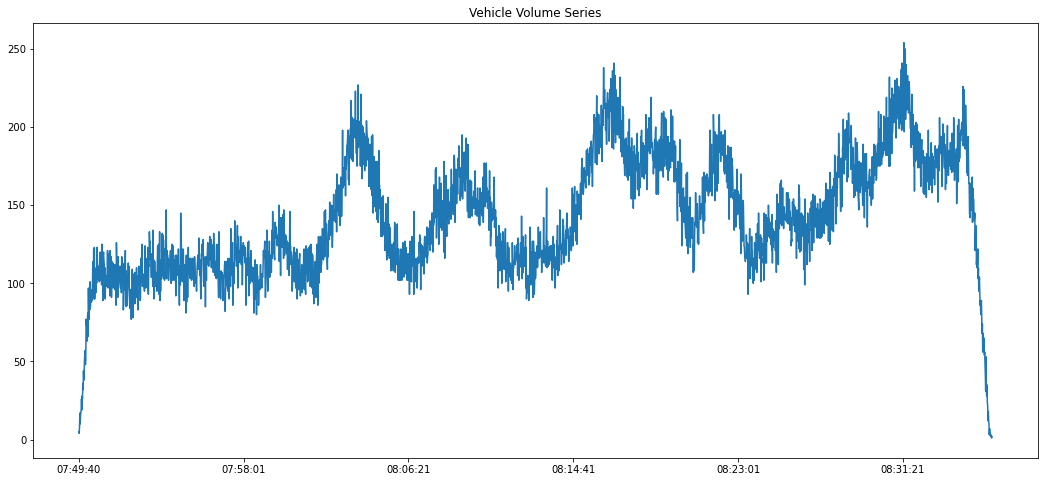

In [254]:
ax = kmeans_pca_df.Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

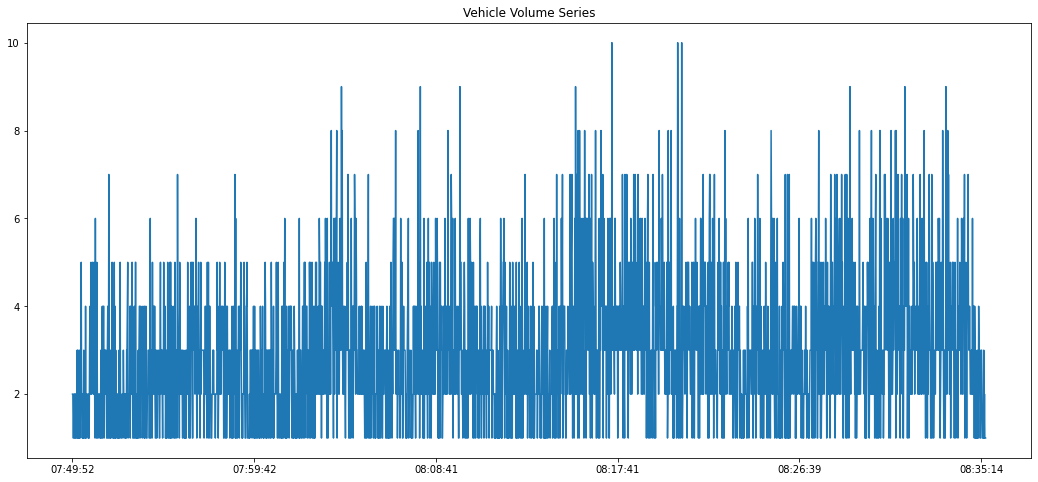

In [255]:
ax = kmeans_pca_df[kmeans_pca_df['Congestion'] == 1].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

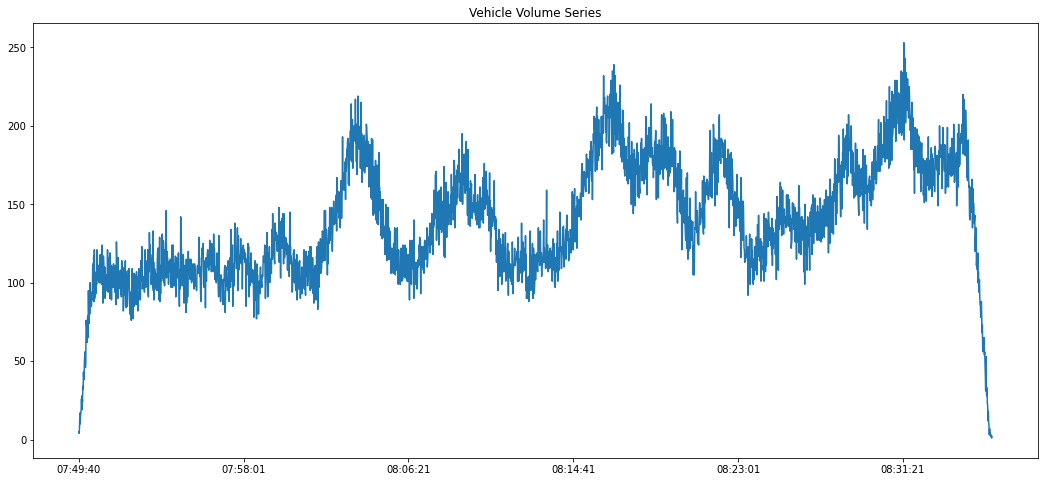

In [256]:
ax = kmeans_pca_df[kmeans_pca_df['Congestion'] == 0].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

### Agglometric Hierarchical Clustering

In [257]:
# agglo_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(pca_cluster)

In [258]:
# agglo_cluster.labels_

In [259]:
# agglo_df = data.iloc[:,:]